In [1]:
from os.path import join
import json
import csv

import rpy2.rinterface
from pandas import read_csv, DataFrame, Series
from qiime2 import Artifact
from statsmodels.stats.weightstats import DescrStatsW
from IPython.display import Image

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library(ggplot2)

In [4]:
empo3_dir = '/Users/benkaehler/Data/empo_3/'

In [13]:
abundances = read_csv(join(empo3_dir, 'abundances.tsv'), sep='\t')
abundances = abundances.set_index(['sample type', 'sample'])
eval_comp = read_csv(join(empo3_dir, 'eval_comp_results.tsv'), sep='\t')
eval_comp = eval_comp.join(abundances, ['sample type', 'sample'])

In [14]:
eval_comp = eval_comp[(eval_comp['sample type'] != 'single-strain') &
          (eval_comp['sample type'] != 'sterile-water-blank') &
          (eval_comp['sample type'] != 'mock-community') &
          (eval_comp['sample type'] != 'plant-surface')]
eval_comp = eval_comp[(eval_comp['class weights'] == 'bespoke70') |
          (eval_comp['class weights'] == 'uniform70')]
eval_comp = eval_comp[eval_comp['abundance'] >= 1000]

In [18]:
grouped = eval_comp.groupby(['sample type', 'class weights', 'level'])
def weighted_stats(x):
    d1 = DescrStatsW(x['Bray-Curtis'])
    lower, upper = d1.tconfint_mean()
    return Series([d1.mean, lower, upper], index=['mean', 'lower', 'upper'])
figure4 = grouped.apply(weighted_stats)
figure4.reset_index(inplace=True)
old_labels = 'uniform70', 'bespoke70'
new_labels = 'Uniform', 'Bespoke'
for old, new in zip(old_labels, new_labels):
    figure4.loc[figure4['class weights'] == old, 'class weights'] = new

In [19]:
%%R -i figure4

cbPalette <- c( "#009E73", "#E69F00")

ggplot(figure4, aes(x=level, y=mean, 
                    group=interaction(sample.type, class.weights),
                    colour=class.weights)) + 
geom_line(alpha=0.4) + geom_smooth(aes(group=class.weights), method='loess') + 
theme_bw() + theme(legend.position="bottom", 
        legend.direction="horizontal") +
  labs(y='Bray-Curtis Similarity', x='Taxonomy Level') +
  scale_colour_manual(values=cbPalette) +
  guides(colour=guide_legend(title="Taxonomic Weights")) +
scale_x_continuous(breaks=c(1, 2, 3, 4, 5, 6, 7),
        labels=c(    'Kingdom',
    'Phylum',
    'Class',
    'Order',
    'Family',
    'Genus',
    'Species'))

ggsave(file="figure4b.png", width=5, height=5, dpi=300)

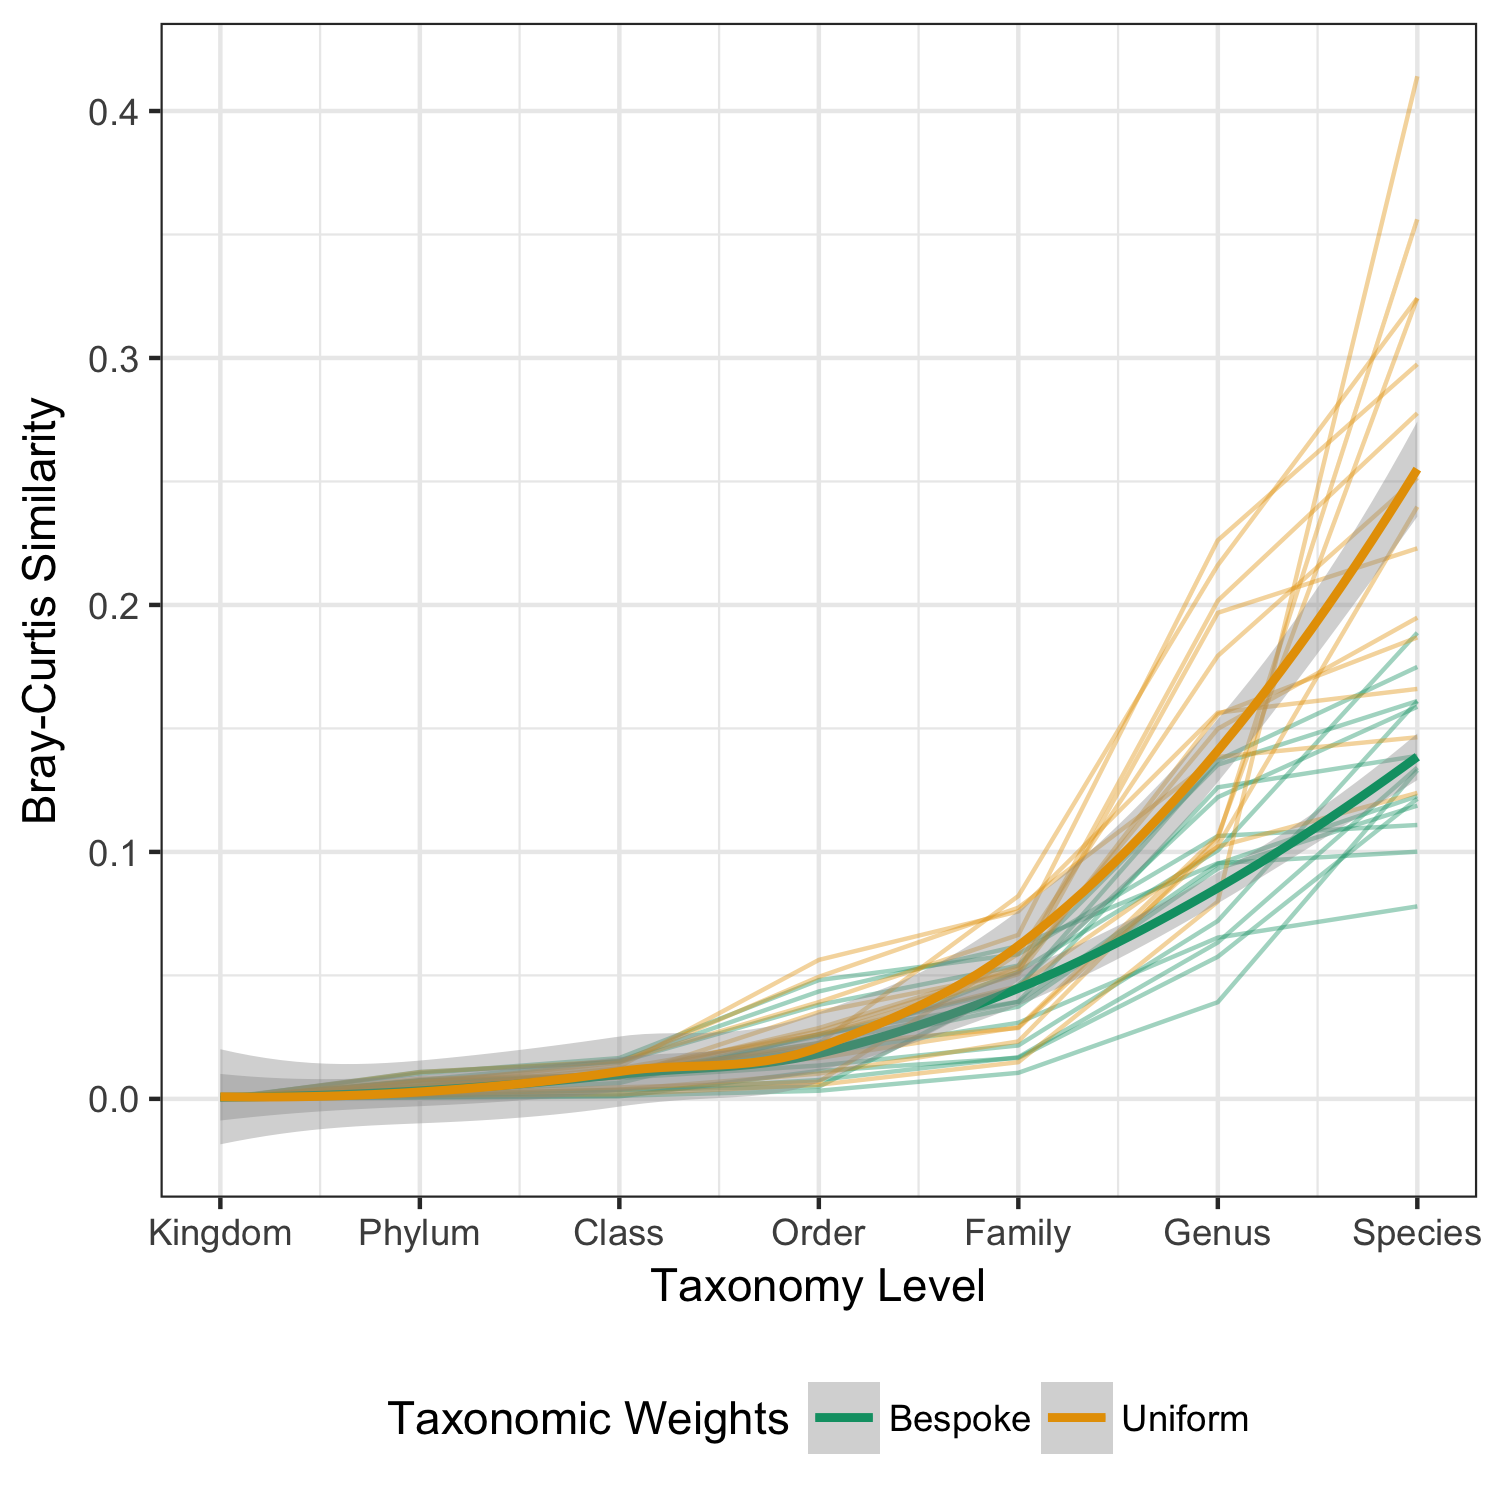

In [20]:
Image("figure4b.png")